In [1]:
using Enzyme, CairoMakie

In [2]:
f(x, ω) = sin(ω * x)

f (generic function with 1 method)

In [3]:
f(1.0, π)

1.2246467991473532e-16

In [13]:
Enzyme.autodiff(Enzyme.ReverseWithPrimal, f, Active(1.0), Const(3.1415))

((-3.141499986515602, nothing), 9.265358966049026e-5)

In [9]:
3.1415 * cos(3.1415 * 1.0)

-3.141499986515602

In [14]:
f(1.0, 3.1415)

9.265358966049026e-5

In [15]:
function f!(r, x, ω)
    r .= sin.(x .* ω)
    return
end

f! (generic function with 1 method)

In [16]:
nx = 10
x  = ones(nx)
r  = zeros(nx)
ω  = float(π)

3.141592653589793

In [20]:
f!(r, x, ω)
r

10-element Vector{Float64}:
 1.2246467991473532e-16
 1.2246467991473532e-16
 1.2246467991473532e-16
 1.2246467991473532e-16
 1.2246467991473532e-16
 1.2246467991473532e-16
 1.2246467991473532e-16
 1.2246467991473532e-16
 1.2246467991473532e-16
 1.2246467991473532e-16

In [21]:
Enzyme.autodiff(Enzyme.Reverse, f!, Active(r), Active(x), Const(ω))

LoadError: Unsupported Active{Vector{Float64}}, consider Duplicated or Const

In [22]:
r̄ = ones(nx)
x̄ = zeros(nx)
Enzyme.autodiff(Enzyme.Reverse, f!, Duplicated(r,r̄), Duplicated(x,x̄), Const(ω))

((nothing, nothing, nothing),)

In [26]:
r̄ .= rand(nx)
Enzyme.autodiff(Enzyme.Reverse, f!, Duplicated(r,r̄), Duplicated(x,x̄), Const(ω))
x̄

10-element Vector{Float64}:
 -5.124994929906903
 -5.282952566702659
 -5.538543117616801
 -4.734654034517073
 -5.709320373359009
 -4.418031189853703
 -6.372403190357334
 -5.94657002551741
 -4.840900797380885
 -7.105176858813211

In [51]:
# linear model
U(λ, X) = λ .* X #log.(X.^5 .+ X.^3 .+ 2.0)

# exact solution
lsq(X, Y) = (X' * X) \ (X' * Y)

# synthetic observation
function generate_synthetic_data(n, λ, σ)
    X = 2.0 .* rand(n) .- 1.0
    Y = U(λ, X) .+ σ .* randn(n)
    return X, Y
end

# objective function
J(λ, X, Y_obs) = sum((U(λ, X) .- Y_obs).^2) / sum(Y_obs .^ 2)

J (generic function with 1 method)

In [54]:
n     = 100
λ_syn = 5.0
σ     = 1.0

X, Y = generate_synthetic_data(n, λ_syn, σ)

λ_lsq = lsq(X, Y)

XX = LinRange(-1, 1, 100)

λs = [0.0]
Js = [J(λs[end], X, Y)]

∇J(λ, X, Y_obs) = Enzyme.autodiff(Enzyme.Reverse, J, Active(λ), Const(X), Const(Y_obs))[1][1]
γ = 5.0

for iter in 1:20
    push!(λs, λs[end] - γ * ∇J(λs[end], X, Y))
    push!(Js, J(λs[end], X, Y))
end

@show λ_syn λ_lsq λs[end]

λ_syn = 5.0
λ_lsq = 2.763077697772163
λs[end] = 4.877644644816225


4.877644644816225

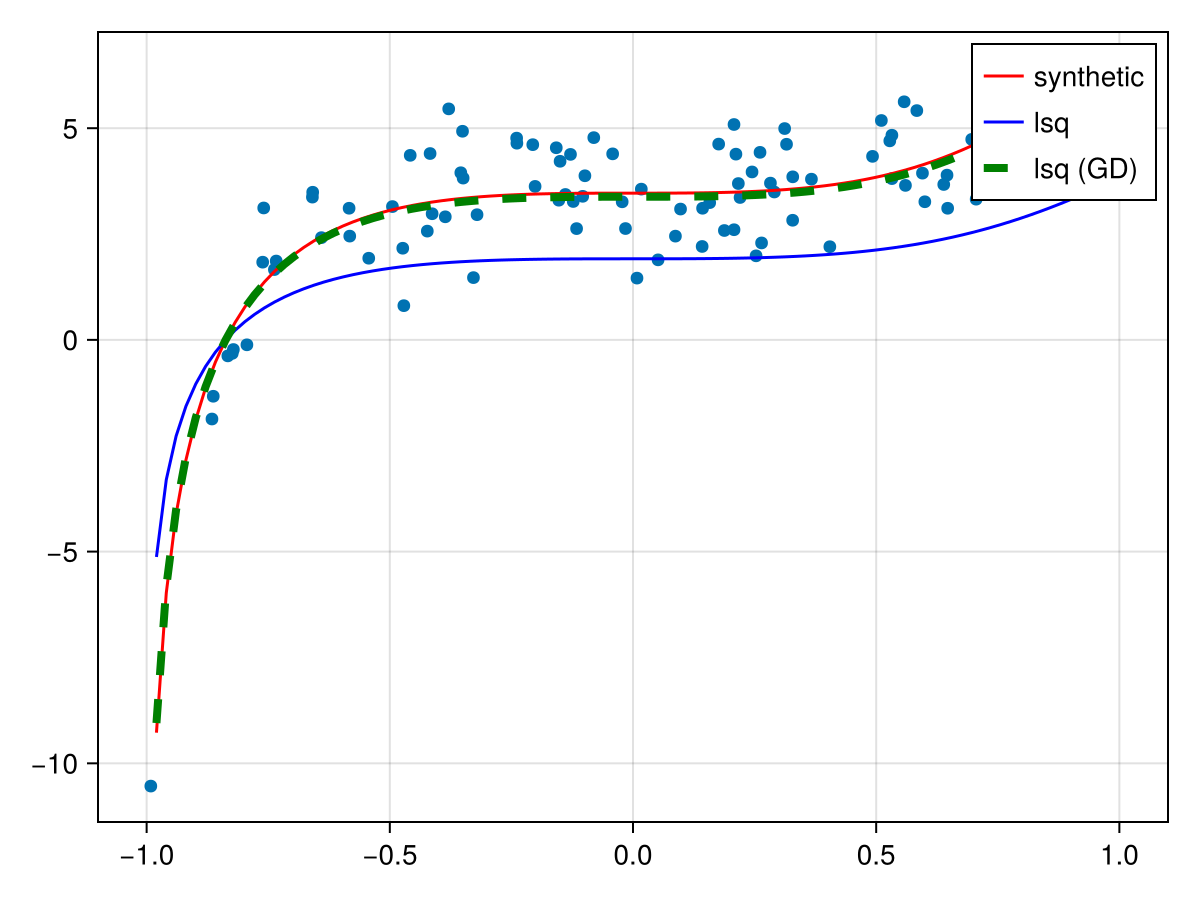

In [55]:
fig = Figure()
ax  = Axis(fig[1,1])

scatter!(ax, X, Y)
lines!(ax, XX, U(λ_syn, XX); color=:red, label="synthetic")
lines!(ax, XX, U(λ_lsq, XX); color=:blue, label="lsq")
plt = lines!(ax, XX, U(λs[1], XX); color=:green, linestyle=:dash, linewidth=4, label="lsq (GD)")

axislegend(ax)

for λ in λs
    plt[2] = U(λ, XX)
    sleep(1/10)
    IJulia.clear_output(true)
    display(fig)
end